In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import time
import pathlib
import os
import matplotlib.pyplot as plt

from PIL import Image
from model.decoder import Decoder
from model.encoder import CNN_Encoder
from model.attention import BahdanauAttention
from model.decoder import embedding_initializer
from components.positional import add_timing_signal_nd
from sklearn.model_selection import train_test_split

## Dataset

In [2]:
data_dir = pathlib.Path("data/small")

In [3]:
imgs = list(data_dir.glob("*.png"))

In [4]:
imgs_paths = []
for img in imgs:
    imgs_paths.append(os.fspath(img))

In [5]:
imgs_paths = sorted(set(imgs_paths))

In [6]:
lines = open("data/small.formulas.norm.txt", 'r').read().split('\n')

In [7]:
for i in range(len(lines)):
    lines[i] = "<start> " + lines[i] + " <end>" 

## Tokenize

In [8]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
top_k = 400

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='')
tokenizer.fit_on_texts(lines)
train_seqs = tokenizer.texts_to_sequences(lines)

In [10]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [11]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [12]:
max_length = calc_max_length(train_seqs)

## Split Dataset

In [13]:
embedding_dim = 80
BATCH_SIZE = 2
units = 512
vocab_size = top_k + 1
attention_features_shape = 64

In [14]:
def load_image(image_path, formula):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img)
    return img, formula

In [15]:
def load_image_only(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = img / 255
    return img 

In [16]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(imgs_paths,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [18]:
dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [19]:
dataset = dataset.shuffle(1000).batch(BATCH_SIZE)

In [20]:
num_steps = len(img_name_train)

## Init Encoder Decoder

In [21]:
encoder = CNN_Encoder(embedding_dim)

In [22]:
decoder = Decoder(embedding_dim, 512, vocab_size=top_k+1,)

## Loss

In [23]:
loss_plot = []

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

## Training

In [25]:
@tf.function
def train_step(img, target):
    loss = 0
    img = img / 255
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img)
        
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)
            
            dec_input = tf.expand_dims(target[:, i], 1)
            
        total_loss = (loss / int(target.shape[1]))
        
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        
        gradients = tape.gradient(loss, trainable_variables)
        
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        return loss, total_loss
    

## Checkpoints

In [26]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [27]:
start_epoch = 0

if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restore to latest cehckpoint
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [28]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, target)
        total_loss += t_loss
    
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        
    loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()
        
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 8 Batch 0 Loss 3.2732
Epoch 8 Loss 1.450055
Time taken for 1 epoch 5.271727085113525 sec

Epoch 9 Batch 0 Loss 1.7428
Epoch 9 Loss 1.102265
Time taken for 1 epoch 0.23688101768493652 sec

Epoch 10 Batch 0 Loss 1.8506
Epoch 10 Loss 0.942810
Time taken for 1 epoch 0.23837709426879883 sec

Epoch 11 Batch 0 Loss 2.0640
Epoch 11 Loss 0.929335
Time taken for 1 epoch 0.5234150886535645 sec

Epoch 12 Batch 0 Loss 1.7022
Epoch 12 Loss 0.899456
Time taken for 1 epoch 0.24530792236328125 sec

Epoch 13 Batch 0 Loss 1.5716
Epoch 13 Loss 0.815287
Time taken for 1 epoch 0.23948907852172852 sec

Epoch 14 Batch 0 Loss 1.5974
Epoch 14 Loss 0.830973
Time taken for 1 epoch 0.24467992782592773 sec

Epoch 15 Batch 0 Loss 2.1093
Epoch 15 Loss 0.763219
Time taken for 1 epoch 0.2456192970275879 sec

Epoch 16 Batch 0 Loss 0.9523
Epoch 16 Loss 0.763099
Time taken for 1 epoch 0.5381748676300049 sec

Epoch 17 Batch 0 Loss 1.4159
Epoch 17 Loss 0.753880
Time taken for 1 epoch 0.2521212100982666 sec

Epoch 18 B

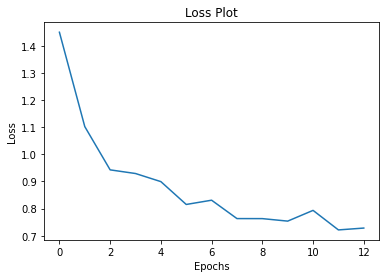

In [29]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [30]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
        
    img = tf.expand_dims(load_image_only(image), 0) 
    
    features = encoder(img)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)
        
    
    attention_plot = attention_plot[:len(result), :]
    
    return result, attention_plot
    
    

In [31]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    
    fig = plt.figure(figsize=(10,10))
    
    len_result = len(result)
    
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent()) 
        
    plt.tight_layout()
    plt.show()

In [32]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Formula:', real_caption)
print ('Prediction Formula:', ' '.join(result))

Real Formula: <start> \frac { \alpha } { \beta } <end>
Prediction Formula: 1 <end>
